# DemoMA_Regression_CCGPMA
### This demo shows an example of regression with multiple annotators by using our model based on correlated chained Gaussian processes for multiple annotators (CCGPMA).

In [1]:
import sys
import climin
from functools import partial
import warnings
import os
sys.path.append('..')

import numpy as np
import pandas as pd
from scipy.stats import multinomial
from scipy import stats
from scipy.linalg.blas import dtrmm
from sklearn.metrics import mean_squared_error, r2_score

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.categorical import Categorical
from likelihoods.hetgaussian import HetGaussian
from likelihoods.beta import Beta
from likelihoods.gamma import Gamma
from likelihoods.exponential import Exponential
from likelihoods.hetgaussianMA import HetGaussianMA

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.svmogp import SVMOGP
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'


from importlib import reload
import random
random.seed(100)

## 1. Regression problem definition 

We assume a 1D regression problem, where input features are given as $x \in [0, 1]$ and $y = \sin(2\pi x)\sin(6\pi x)$

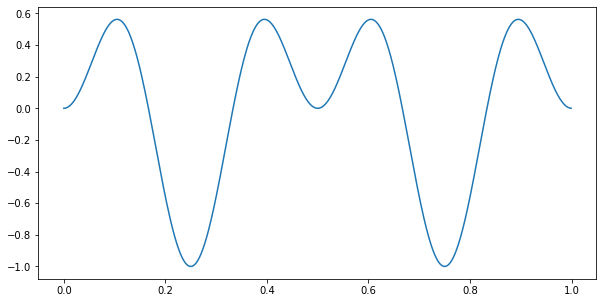

In [2]:
step = 1/1000
X = np.arange(0, 1, step)
y = np.sin(2*np.pi*X)*np.sin(6*np.pi*X)
plt.figure(figsize=(10, 5))
plt.plot(X, y)
plt.show()

To define the training set, we randomly obtain $N=100$ samples from the interval $[0, 1]$. Conversely, for the test set, we sample uniformly $200$ points from $[0, 1]$

In [3]:
seed = 0
np.random.seed(seed)
N = 100
Ntest = 200
Xtrain = np.random.rand(N)
Xtrain = np.sort(Xtrain, axis=None)
Xtrain = Xtrain.reshape((N,1))
ytrain = np.sin(2*np.pi*Xtrain)*np.sin(6*np.pi*Xtrain)
Xtest = np.linspace(0, 1, Ntest).reshape((Ntest,1))
ytest = np.sin(2*np.pi*Xtest)*np.sin(6*np.pi*Xtest)

# 2. Multiple annotators simulation

To simulate labels from multiple annotators, we assume them to correspond to corrupted versions of the ground truth. Thus, the label given by the $r$-th annotator to the label $n$ is given as $$y_n^r = y_n + \epsilon_n^r,$$
where $\epsilon_n^r \sim \mathcal{N}(0, v_{r,n})$. Here $v_{r,n} = v_r(\mathbf{x}_n)$ is the error variance for the $r$-th annotator, which is related to its performance. Here, we model such variances as functions of the input space and taking into account dependencies among the annotators. Thus, each function $v_{r,n}$ is built as $v_{r}(\cdot) = e^{f_r(\cdot)}$ to ensure positivity. $g_r(\cdot)$ is computed as a combination of $Q$ latent functions $u_q(\cdot)$, with $q\in\{1, \dots , Q\}$.

First, we define some parameters related to the labelers

In [4]:
R = 5 # Number of annotators
NrP = 1.0 # the percentage of samples labeled by each annotator

Second, we define the functions $u_q(\cdot)$ and the combination parameters $w_{r,q}$

In [5]:
u_q = np.empty((Xtrain.shape[0],2))
u_q[:,0,None] = 4.5*np.cos(2*np.pi*Xtrain + 1.5*np.pi) - \
                           3*np.sin(4.3*np.pi*Xtrain + 0.3*np.pi) + \
                           4*np.cos(7*np.pi * Xtrain + 2.4*np.pi)
                
u_q[:,1,None] = 4.5*np.cos(1.5*np.pi*Xtrain + 0.5*np.pi) + \
                   5*np.sin(3*np.pi*Xtrain + 1.5*np.pi) - \
                   4.5*np.cos(8*np.pi * Xtrain + 0.25*np.pi)

W = []
# q=1
Wq1 = np.array(([[-0.5],[0.1],[-0.2],[0.6],[-0.2]]))
W.append(Wq1)
# q=2
Wq2 = np.array(([[-0.1],[.6],[0.1],[-0.5],[0.3]]))
W.append(Wq2)

Third, we define the functions $f_r(\cdot)$, by combining the functions $u_q(\cdot)$ using the parameters $w_{r,q}$. Besides, we define the annotator variance as $v_{r}(\cdot) = e^{f_r(\cdot)}$

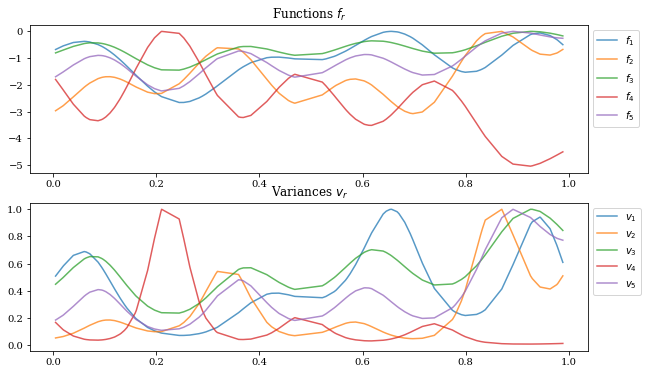

In [6]:
F_r = []
V_r = []
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.figure(figsize=(10, 6))
for r in range(R):
    f_r = np.zeros((Xtrain.shape[0], 1))
    v_r = np.zeros((Xtrain.shape[0], 1))
    for q in range(2):
        f_r += W[q][r].T*0.3*u_q[:,q,None]
    f_r = f_r - f_r.max() # We do this to guarantee that the maximum value of v_r is 1.
    F_r.append(f_r)
    v_r = np.exp(f_r)
    V_r.append(v_r)
    
    #Plots
    plt.subplot(2,1,1)
    plt.plot(Xtrain, f_r, alpha=0.75, label='$f_'+str(r+1)+'$')   
    plt.subplot(2,1,2)
    plt.plot(Xtrain, v_r, alpha=0.75, label='$v_'+str(r+1)+'$') 
plt.subplot(2,1,1)
plt.title(r'Functions $f_r$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.subplot(2,1,2)
plt.title(r'Variances $v_r$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Fourth, given the variances, we simulate the annotations from multiple labelers.

In [7]:
seed = 0
np.random.seed(seed)
Ytrain = np.ones((N, R))
for r in range(R):
    Ytrain[:,r] = (ytrain + np.random.normal(0,1,(N,1))*np.sqrt(V_r[r])).flatten()

Finally, it is common to find that the labelers do not have access to the entire dataset. Hence, we simulate such a scenario by introducing a binary variable $ian_{r,n}$, which is one if the annotator $r$ labeled the instance $n$, and zero in otherwise.

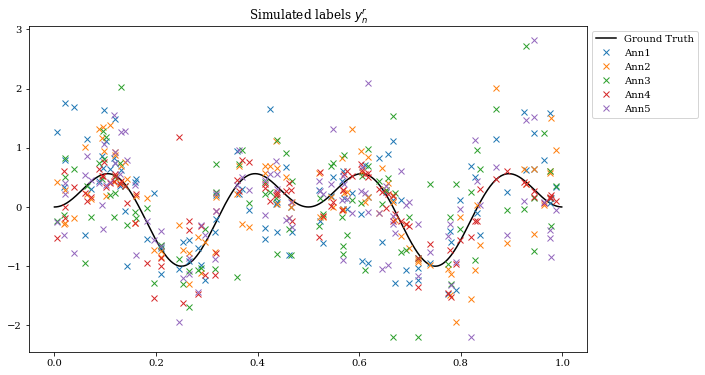

In [8]:
seed = 0
np.random.seed(seed)
iAnn = np.zeros((N, R), dtype=int) # this indicates if the annotator r labels the nth sample.
Nr = np.ones((R), dtype=int)*int(np.floor(N*NrP))  
for r in range(R):
    if r < R-1:
        indexR = np.random.permutation(range(N))[:Nr[r]]
        iAnn[indexR,r] = 1
    else:
        iSimm = np.sum(iAnn, axis=1)
        idxZero = np.asarray([i for (i, val) in enumerate(iSimm) if val == 0])
        Nzeros = idxZero.shape[0]
        idx2Choose = np.arange(N)
        if Nzeros == 0:
            indexR = np.random.permutation(range(N))[:Nr[r]]
            iAnn[indexR,r] = 1
        else:
            idx2Choose = np.delete(idx2Choose, idxZero)
            N2chose = idx2Choose.shape[0]
            idxNoZero = np.random.permutation(N2chose)[:(Nr[r] - Nzeros)]
            idxTot = np.concatenate((idxZero, idx2Choose[idxNoZero]))
            iAnn[idxTot,r] = 1

# Now, we verify that all the samples were labeled at least once
Nr = (np.sum(iAnn,0))
iSimm = np.sum(iAnn, axis=1)
if np.asarray([i for (i, val) in enumerate(iSimm) if val == 0]).sum() == 0:
    ValueError("all the samples must be labeled at least once")
    
# Finally, if iAnn=0 we assign a reference value to indicate a missing value
Vref = -1e-20
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.plot(X, y, 'k', label='Ground Truth')
for r in range(R):
    Ytrain[iAnn[:,r] == 0, r] = Vref 
    plt.plot(Xtrain[iAnn[:,r] == 1, :], Ytrain[iAnn[:,r] == 1, r], 'x', label='Ann'+str(r+1))

Ymax = Ytrain.flatten().max()
plt.title(r'Simulated labels $y_n^r$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## 3. Chained Gaussian processes for multiple annotators (CGPMA)
We use CGPMA to solve the multi-class classification problem in the context of multiple annotators. This approach computes the annotators' parameters as a function of the input space, and it assumes independence among the labelers.

In [9]:
#Likelihood
likelihoods_list = [HetGaussianMA()] # HetGaussianMA
iAnn_list = [iAnn]
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata(iAnn_list)
D = likelihood.num_output_functions(Y_metadata)

In [10]:
# KERNELS
M = 10  # number of inducing points
Q = R+1  # number of latent functions

ls_q = np.array(([.05]*Q))
var_q = np.array(([.5]*Q))
kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=1)

# # INDUCING POINTS
minX = Xtrain.min()
maxX = Xtrain.max()
Z = np.linspace(0, 1, M)
Z = Z[:, np.newaxis]

In [11]:
chained = True
modelC = SVMOGP(X=[Xtrain.copy()], Y=[Ytrain.copy()], Z=Z.copy(),
               kern_list=kern_list, likelihood=likelihood,
               Y_metadata=Y_metadata, batch_size=100,
               non_chained=(not chained))
modelC['.*.W'].fix()

In [12]:
def callback(i):
    global n_iter
    if (i['n_iter']) % 50 == 0:
        print("Iteration:",i['n_iter'])
        print(modelC.log_likelihood())
    if i['n_iter'] > n_iter:
        return True
    return False

In [13]:
n_iter = 500
optC = climin.Adam(modelC.optimizer_array, modelC.stochastic_grad, step_rate=0.02,decay_mom1=1 - 0.9, decay_mom2=1 - 0.999)
infoC = optC.minimize_until(callback)

Iteration: 50
[[-610.96173679]]
Iteration: 100
[[-541.73818025]]
Iteration: 150
[[-476.800518]]
Iteration: 200
[[-460.50277842]]
Iteration: 250
[[-457.22297615]]
Iteration: 300
[[-454.54311559]]
Iteration: 350
[[-450.59603213]]
Iteration: 400
[[-449.34414984]]
Iteration: 450
[[-450.34712326]]
Iteration: 500
[[-448.69368544]]


## 4. Correlated Chained Gaussian processes for multiple annotators (CCGPMA)
We use CCGPMA to solve the multi-class classification problem in the context of multiple annotators. This approach computes the annotators' parameters as a function of the input space, and codes inter-annotator dependencies.

In [14]:
#Likelihood
likelihoods_list = [HetGaussianMA()] # HetGaussianMA
iAnn_list = [iAnn]
likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata(iAnn_list)
D = likelihood.num_output_functions(Y_metadata)

In [15]:
# KERNELS
M = 10  # number of inducing points
Q = R+1  # number of latent functions

ls_q = np.array(([.05]*Q))
var_q = np.array(([.5]*Q))
kern_list = util.latent_functions_prior(Q, lenghtscale=ls_q, variance=var_q, input_dim=1)

# # INDUCING POINTS
minX = Xtrain.min()
maxX = Xtrain.max()
Z = np.linspace(0, 1, M)
Z = Z[:, np.newaxis]

In [16]:
chained = False
model = SVMOGP(X=[Xtrain.copy()], Y=[Ytrain.copy()], Z=Z.copy(),
               kern_list=kern_list, likelihood=likelihood,
               Y_metadata=Y_metadata, batch_size=100,
               non_chained=(not chained))

In [17]:
def callback(i):
    global n_iter
    if (i['n_iter']) % 50 == 0:
        print("Iteration:",i['n_iter'])
        print(model.log_likelihood())
    if i['n_iter'] > n_iter:
        return True
    return False

In [18]:
n_iter = 500
opt = climin.Adam(model.optimizer_array, model.stochastic_grad, step_rate=0.02,decay_mom1=1 - 0.9, decay_mom2=1 - 0.999)
info = opt.minimize_until(callback)

Iteration: 50
[[-642.63464641]]
Iteration: 100
[[-598.60787709]]
Iteration: 150
[[-514.73068352]]
Iteration: 200
[[-469.94198587]]
Iteration: 250
[[-454.53401504]]
Iteration: 300
[[-445.30127199]]
Iteration: 350
[[-429.10210788]]
Iteration: 400
[[-422.9146858]]
Iteration: 450
[[-417.76971568]]
Iteration: 500
[[-415.47591216]]


## 5. Figures  and Perfomance assessment

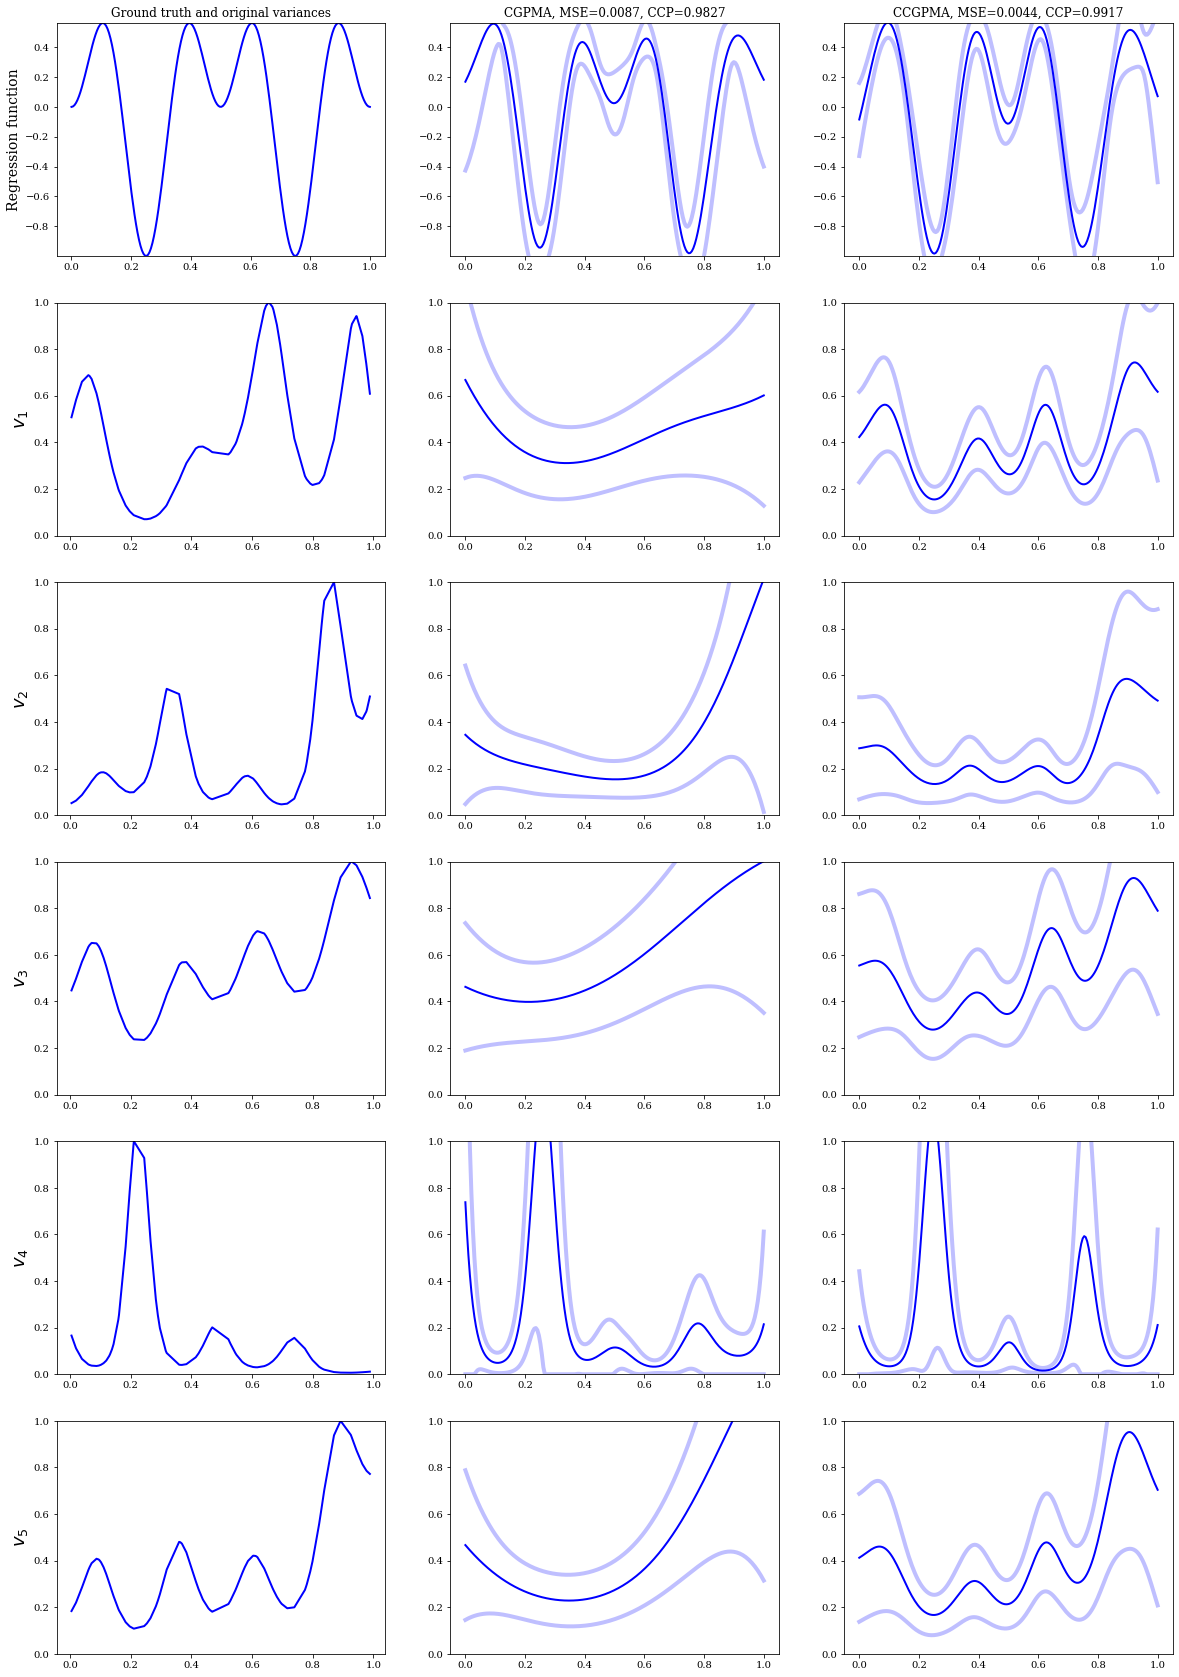

In [19]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.figure(figsize=(20, 30))

Mc, Vc = modelC.predictive_new([Xtest.copy()], output_function_ind=0)
M, V = model.predictive_new([Xtest], output_function_ind=0)
for r in range(R+1):
    # Original Values
    miny = ytest.min()
    maxy = ytest.max()
    if r ==0:
        plt.subplot(R+1,3, 3*r+1)
        plt.plot(Xtest, ytest, 'b-', linewidth=2, alpha=1)
        plt.ylabel("Regression function",fontsize=14)
        plt.ylim(miny, maxy)
    else:
        plt.subplot(R+1,3, 3*r+1)
        plt.plot(Xtrain, V_r[r-1], 'b-', linewidth=2, alpha=1)
        plt.ylabel(r"$v_"+str(r)+'$', fontsize=18)
        plt.ylim(0, 1)
    
    # CGP
    mfc, vfc = Mc[r], Vc[r]
    mf_upperc = mfc + 2*np.sqrt(vfc)
    mf_lowerc = mfc - 2*np.sqrt(vfc)
    if r > 0:
        mf_upperc[mf_upperc<0] = 0
        mf_lowerc[mf_lowerc<0] = 0
        plt.subplot(R+1,3, 3*r+2)
        plt.plot(Xtest, mfc, 'b-', linewidth=2, alpha=1)
        plt.plot(Xtest, mf_upperc, 'b-', linewidth=4, alpha=0.25)
        plt.plot(Xtest, mf_lowerc, 'b-', linewidth=4, alpha=0.25)
        plt.ylim(0, 1)
    else:
        plt.subplot(R+1,3, 3*r+2)
        plt.plot(Xtest, mfc, 'b-', linewidth=2, alpha=1)
        plt.plot(Xtest, mf_upperc, 'b-', linewidth=4, alpha=0.25)
        plt.plot(Xtest, mf_lowerc, 'b-', linewidth=4, alpha=0.25)
        plt.ylim(miny, maxy)
    
    
    #CCGP
    mf, vf = M[r], V[r]
    mf_upper = mf + 2*np.sqrt(vf)
    mf_lower = mf - 2*np.sqrt(vf)
    if r > 0:
        mf_upper[mf_upper<0] = 0
        mf_lower[mf_lower<0] = 0
        plt.subplot(R+1,3, 3*r+3)
        plt.plot(Xtest, mf, 'b-', linewidth=2, alpha=1)
        plt.plot(Xtest, mf_upper, 'b-', linewidth=4, alpha=0.25)
        plt.plot(Xtest, mf_lower, 'b-', linewidth=4, alpha=0.25)
        plt.ylim(0, 1)
    else:
        plt.subplot(R+1,3, 3*r+3)
        plt.plot(Xtest, mf, 'b-', linewidth=2, alpha=1)
        plt.plot(Xtest, mf_upper, 'b-', linewidth=4, alpha=0.25)
        plt.plot(Xtest, mf_lower, 'b-', linewidth=4, alpha=0.25)
        plt.ylim(miny, maxy)
        
# Regression performance
PearCGP, _ = stats.pearsonr(ytest.flatten(), Mc[0].flatten())
PearCCGP, _ = stats.pearsonr(ytest.flatten(), M[0].flatten())
MSE_CGP = mean_squared_error(ytest.flatten(), Mc[0].flatten())
MSE_CCGP = mean_squared_error(ytest.flatten(), M[0].flatten())

plt.subplot(R+1,3,1)
plt.title('Ground truth and original variances')
plt.subplot(R+1,3,2)
plt.title('CGPMA, '+'MSE='+"{:.4f}".format(MSE_CGP)+', CCP='"{:.4f}".format(PearCGP))
plt.subplot(R+1,3,3)
plt.title('CCGPMA, ' +'MSE='+"{:.4f}".format(MSE_CCGP)+', CCP='"{:.4f}".format(PearCCGP))
plt.show()
